# Reinforcement Learning (RL)

Reinforcement Learning (RL) is a branch of machine learning where an agent learns to make decisions by interacting with an environment. Instead of being told what the correct action is, the agent explores different actions and learns from the consequences of those actions in terms of rewards.

<div align="center">
<img src="https://gymnasium.farama.org/_images/AE_loop.png" alt="RL Diagram" width="600"/>
</div>

At the core of RL are a few key concepts:
- **Environment:** The world in which the agent operates (e.g., a game, robot control, or simulation).
- **State (s)**: A representation of the current situation of the environment.
- **Action (a)**: A choice the agent can make.
- **Reward (r)**: A scalar feedback signal received after performing an action.
- **Policy (π)**: A mapping from states to actions — essentially, the agent’s strategy.
- **Episode**: A sequence of states, actions, and rewards from start to terminal condition.

The goal of reinforcement learning is to find an optimal policy that maximizes the expected cumulative reward (also called the return).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from collections import namedtuple, deque
import math, random, time

import torch
import torch.nn as nn
import torch.nn.functional as F

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from gymnasium import spaces

from IPython import display
import time




## 2. The FrozenLake Environment

FrozenLake is a **classic grid-world environment** for reinforcement learning. The agent must navigate a **slippery frozen lake** to reach a goal while avoiding holes. We will use the **FrozenLake environment provided by [Gymnasium API](https://gymnasium.farama.org)**, which has the following key components:

- **States (S):** Each cell of the grid represents a state. For a 4×4 grid, there are **16 discrete states** numbered `0–15`.  

- **Actions (A):** The agent can move in **4 directions**:  
    - 0: Move left
    - 1: Move down
    - 2: Move right
    - 3: Move up
 
- **Rewards (R):**
    - Reaching the **goal (G)** → +1 reward  
    - Falling into a **hole (H)** → 0 reward  
    - Every other move → 0 reward  

- **Goal:** Navigate from the **start (S)** to the **goal (G)** safely.

### Additional details:

- The environment can be **slippery** (`is_slippery=True`), meaning the agent may slide to unintended directions, introducing **stochasticity**.  
- Each episode ends when the agent **reaches the goal**, **falls into a hole** or **perform a maximum number of interactions with the enviroment**.

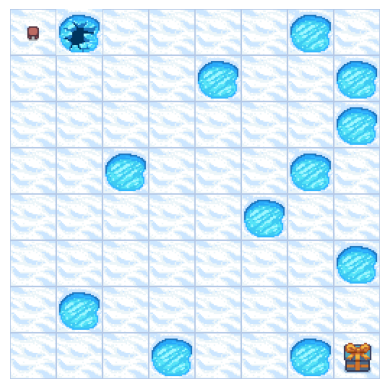

In [2]:
# Problem parameters
num_episodes, max_steps, seed, map_size, frozen_prob = 5, 100, 42, 8, 0.8

# Initialise the environment
env = gym.make("FrozenLake-v1", render_mode="rgb_array", is_slippery=False, max_episode_steps=max_steps,
                desc=generate_random_map(size=map_size, p=frozen_prob))


fig, ax = plt.subplots()
for episode in range(num_episodes):
    
    # Reset the environment to start a new episode and get the initial state (observation)
    observation, info = env.reset(seed=seed)
    
    done = False
    while not done:
        # Select an action using the policy (here: random policy)
        action = env.action_space.sample()

        # Take the action, observe the next state observation, collect reward
        observation, reward, terminated, truncated, info = env.step(action)        

        # Learns from the experience (state, action, reward, next_state)
        # (This part is omitted in this simple example)

        # code for rendering in notebook
        img = env.render()
        ax.clear(); ax.imshow(img); ax.axis("off");
        display.display(fig)        # show the figure
        display.clear_output(wait=True)  # clear previous frame
        time.sleep(0.5)  

        # Check if the episode has finished (reached terminal or truncated state)
        done = terminated or truncated

# Close the environment after all episodes are done
env.close()
plt.close()

We are going to solve this problem with **Q-Learning** and **Deep Q-Learning** algorithms.  We will also observe how the **policy learned changes** as we vary the environment where the agent is trained.  

Consider the following ways to modify the environment or problem setup:


- **Change the map layout and size**  
  - Use a **custom `desc`** instead of a random map to design specific layouts.  
  - Place **holes (`H`) or the goal (`G`) differently**, or experiment with **different start positions**.  
  - Adjust the **grid size** (`map_size=4` → 4×4, `map_size=8` → 8×8, etc.).  
  - Larger or more complex maps require **more planning and exploration**, leading to potentially different policies.

- **Modify the stochasticity of the environment**  
  - `is_slippery=True` → actions may **slide to unintended directions** (stochastic).  
  - `is_slippery=False` → **deterministic environment**.  
  - This changes how **robust** the agent’s policy needs to be to reach the goal reliably.

  - **Change the reward structure**  
    - By default: **goal = +1**, **hole = 0**, all other moves = 0.  
    - We can experiment with **penalizing holes**, **rewarding safe steps**, or **adjusting rewards** to encourage different behaviors and policies.





## 3. Q-Learning (Tabular RL)

Imagine you are teaching a robot to navigate **FrozenLake**. At first, the robot has **no idea** which actions are good or bad — it just moves randomly and occasionally falls into holes. How can it learn to reach the goal safely and efficiently? This is exactly what **Q-Learning** does: it lets the agent **learn from experience**, step by step, by remembering the value of each action in each state.

### 3.1 The Agent’s Memory: The Q-Table

The agent keeps a **(Q-table) Q(s, a)**, where each row is a **state** (e.g., a cell in the FrozenLake) and each column is an **action** (left, down, right, up).  Initially, all entries are zero — the robot doesn’t know anything yet. Over time, it **takes actions** based on this table and **updates** it using the **rewards received** from the environment.

### 3.2 Taking Actions: The ε-Greedy Strategy

At the beginning, the agent must **explore** — it doesn’t know which actions are safe. But it also wants to **exploit** what it already learned.  

Q-Learning uses an **ε-greedy strategy**:

$$
a_t =
\begin{cases}
\text{random action} & \text{with probability } \epsilon \\
\arg\max_a Q(s_t, a) & \text{with probability } 1 - \epsilon
\end{cases}
$$

- With probability **ε**, it **tries something new**.  
- With probability **1−ε**, it **chooses the best-known action**.  
- Over time, ε can **decay**, letting the agent rely more on what it has learned. A common decay schedule is exponential:

$$
\epsilon_\text{threshold} = \epsilon_\text{end} + (\epsilon_\text{start} - \epsilon_\text{end}) \cdot \exp\Big(-\frac{\text{steps\_done}}{\epsilon_\text{decay}}\Big)
$$

Where:

- $\epsilon_\text{start}$ → initial exploration rate (e.g., 1.0)  
- $\epsilon_\text{end}$ → minimum exploration rate (e.g., 0.01)  
- $\text{steps\_done}$ → number of steps taken so far  
- $\epsilon_\text{decay}$ → decay factor controlling **how fast ε decreases**. Larger values of $ε_{decay}$ make ε decay more slowly.



### 3.2 Learning from Experience: The Bellman Equation

Each time the agent takes an action and sees the result, it updates the Q-table using a simple rule, called the **Bellman equation**:

$$
Q(s_t, a_t) \;\leftarrow\; Q(s_t, a_t) + \alpha 
\underbrace{\Big[ r_{t+1} + \gamma \max_{a'} Q(s_{t+1}, a') - Q(s_t, a_t) \Big]}_{\text{Temporal Difference (TD) Error}}
$$


Let’s break it down:
1. The agent is in **state $s_t$** and takes **action $a_t$**.  
2. The environment gives it a **reward $r_{t+1}$** and moves it to **state $s_{t+1}$**.  
3. The agent looks at the **best possible future action** from $s_{t+1}$ ($max_{a'} Q(s_{t+1}, a')$).  
4. The agent calculates the **temporal difference (TD) error** by comparing what happened (reward + best future action value) with  what you thought before $Q(s_t, a_t)$.
5. It updates its memory $Q(s_t, a_t)$ a little bit ($\alpha$) using the TD error to reflect this experience.


Over many episodes, the Q-table gradually **learns the expected return** of each action in every state, guiding the agent toward the goal. **Let's code it!!**




In [3]:
class Qlearning:
    def __init__(self, state_size, action_size, learning_rate, gamma, eps_start=0.9, eps_end=0.01, eps_decay=2500):
        """Initialize the Q-learning agent."""
        super(Qlearning, self).__init__()

        # qtable is a 2D array where rows are states and columns are actions
        self.state_size, self.action_size = state_size, action_size
        self.qtable = np.zeros((self.state_size, self.action_size))

        # learning parameters
        self.learning_rate, self.gamma = learning_rate, gamma

        # epsilon greedy parameters.
        self.eps_start, self.eps_end, self.eps_decay = eps_start, eps_end, eps_decay
        self.epsilon, self.steps_done = self.eps_start, 0


    def select_action(self, action_space, state):
        """Choose an action `a` in the current world state (s) using epsilon-greedy strategy."""        
        
        # Decay epsilon
        self.epsilon = self.eps_end + (self.eps_start - self.eps_end) * np.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1
        
        # First we randomize a number
        explor_exploit_tradeoff = np.random.uniform(0, 1)

        # Exploration
        if explor_exploit_tradeoff < self.epsilon:
            action = action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        else:            
            max_ids = np.where(self.qtable[state, :] == max(self.qtable[state, :]))[0]
            action = np.random.choice(max_ids)
        
        return action


    def update(self, state, action, reward, new_state):
        """Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        # compute the Q value update
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        
        # update the Q-table with the new Q value
        self.qtable[state, action] = q_update
        
        return q_update


Let's use our Q-learning agent in the Frozen Lake enviroment...

In [4]:
# store data to plot
ql_plot_data = {'episodes': [], 'steps': [], 'rewards': []}
ql_epsilon_values = []

# Initialise the environment
map_size = 8
env = gym.make("FrozenLake-v1", render_mode="rgb_array", is_slippery=False, desc=generate_random_map(size=map_size, p=0.8))

# set number of episode to learn from
num_episodes = 50000

# setup q-learning and epsilon-greedy
ql_agent = Qlearning(state_size=env.observation_space.n, action_size=env.action_space.n, learning_rate=0.8, gamma=0.95, eps_decay=1e5)


# Run Q-learning algorithm
for episode in tqdm(range(num_episodes), desc=f"Episode", total=num_episodes):
    state = env.reset()[0]  # Reset the environment to start a new episode
    done, num_steps, total_reward = False, 0, 0.0
    
    while not done:
        # select an action (a) using the epsilon-greedy policy
        action = ql_agent.select_action(action_space=env.action_space, state=state)
        ql_epsilon_values.append(ql_agent.epsilon)

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, terminated, truncated, info = env.step(action)

        # Update Q(s,a)
        ql_agent.update(state, action, reward, new_state)

        # Our new state is state
        state = new_state

        # check if the episode is finished
        done = terminated or truncated

        # update statistics
        total_reward += reward
        num_steps += 1

    # store episode data
    ql_plot_data['episodes'].append(episode)
    ql_plot_data['steps'].append(num_steps)
    ql_plot_data['rewards'].append(total_reward)
    

env.close()

Episode: 100%|██████████| 50000/50000 [00:12<00:00, 4126.46it/s]


Now, plot the learned policy and reward curves for our Q-Learning agent. You can also experiment with different settings to see how they affect the agent’s learning and behavior. For example:
- Vary the **learning rate (α)** and **discount factor (γ)** in the Bellman equation.
- Adjust the **ε-decay schedule** in action selection to control how fast the agent shifts from exploration to exploitation.
- Modify the **reward scheme** (e.g., penalize falling into holes, reward safe moves).
- Try out different environment configurations **(map size, slipperiness, custom layouts)**.

In [5]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))    
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

def plot_steps_rewards_epsilons(data_collected, eps_values):    
    """Plot the steps and rewards from dataframes."""
    rewards_df = pd.DataFrame(data_collected)
    rewards_df.set_index('episodes', inplace=True)

    rewards_df['rewards'] = rewards_df['rewards'].astype(float).rolling(window=100).mean()
    rewards_df['steps'] = rewards_df['steps'].astype(float).rolling(window=100).mean()

    with sns.plotting_context("paper"), sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
        sns.lineplot(data=rewards_df, x="episodes", y="rewards", ax=ax[0])
        ax[0].set(ylabel="Average rewards", xlabel="Episodes")
        ax[0].grid(True)

        sns.lineplot(data=rewards_df, x="episodes", y="steps", ax=ax[1])
        ax[1].set(ylabel="Number of Steps", xlabel="Episodes")
        ax[1].grid(True)

        sns.lineplot(x=range(len(eps_values)), y=eps_values, ax=ax[2])
        ax[2].set(ylabel="Epsilon", xlabel="Total Steps")
        ax[2].grid(True)

        fig.tight_layout()
        plt.show()

Total number of parameters in Q-table (map_size*map_size*num_actions): 256


error: XDG_RUNTIME_DIR is invalid or not set in the environment.


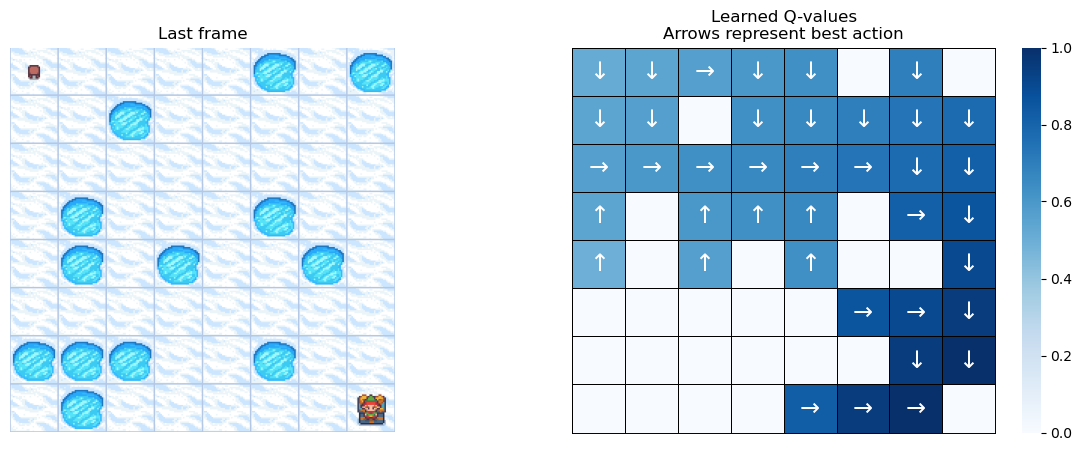

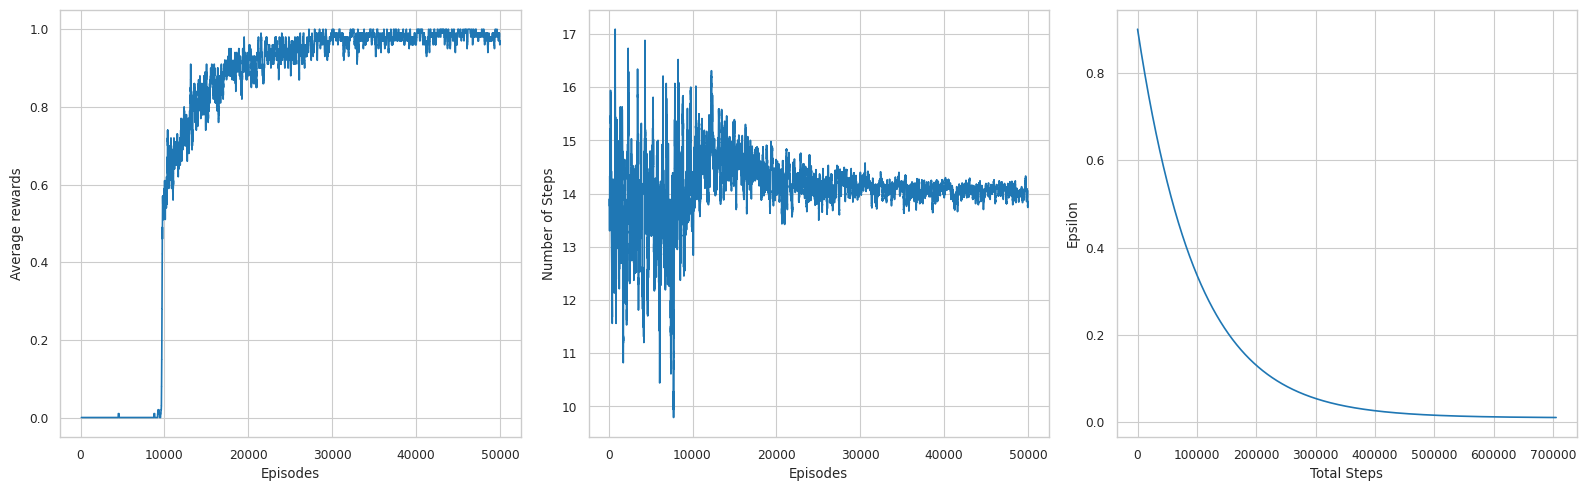

In [6]:
print("Total number of parameters in Q-table (map_size*map_size*num_actions):", ql_agent.qtable.size)
plot_q_values_map(ql_agent.qtable, env, map_size)
plot_steps_rewards_epsilons(ql_plot_data, ql_epsilon_values)

We can also test the learned policy under different conditions, such as changing the starting point, to analyze how it behaves.

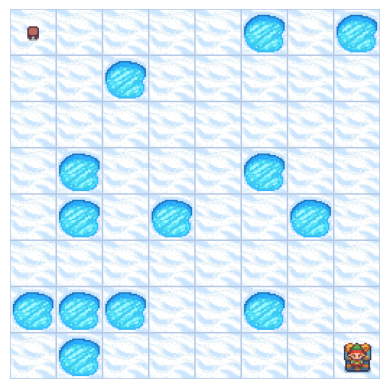

In [12]:
fig, ax = plt.subplots()

# Reset environment
state, info = env.reset()

# Teleport agent
env.unwrapped.s = 40
state = env.unwrapped.s   # update observation

done = False
while not done:
    # select an action (a) using the epsilon-greedy policy
    action = ql_agent.select_action(action_space=env.action_space, state=state)

    # Take the action (a) and observe the outcome state(s') and reward (r)
    new_state, reward, terminated, truncated, info = env.step(action)

    # code for rendering in notebook
    ax.clear(); ax.imshow(env.render()); ax.axis("off");
    display.display(fig); display.clear_output(wait=True);
    time.sleep(0.5)  

    # Our new state is state
    state = new_state

    # check if the episode is finished
    done = terminated or truncated

# Close the environment after all episodes are done
env.close()
plt.close()

### 3.3 When Tabular Q-Learning Struggles  

Tabular Q-Learning is effective for **small environments** like FrozenLake, but it faces serious challenges in real-world scenarios:  

- **Scalability:** In very large or continuous state spaces, the Q-table grows exponentially and quickly becomes unmanageable.  
- **Generalization:** Each state is treated independently, so the agent cannot transfer knowledge from one state to similar ones.  
- **Memory & computation:** Storing and updating massive tables is inefficient and often infeasible in practice.  
  

These limitations motivate **Deep Q-Learning**, which we will see next!

## 4. Deep Q-Learning

Instead of storing Q-values in a table, It trains a neural network, aka **policy network**, to *approximate* the Q-function:
$$
Q(s, a; \theta) \approx Q^*(s, a),
$$
where $\theta$ is the network’s weights. For each state $s$ (e.g., grid position in frozen lake), the network outputs a vector of Q-values — one for each possible action. 

### How do we train such a network?  

To train a Deep Q-Network, we need **target values** for each state-action pair.  A natural choice would be:

$$
y_t = r_{t+1} + \gamma \max_{a'} Q(s_{t+1}, a'; \theta),
$$

where $Q(s_{t+1}, a'; \theta)$ comes from the **same network** we are training.  However, using the same network for **prediction** and **target generation** makes training unstable — the network ends up chasing a **moving target**.

#### The Solution: Target Network

We keep a **target network**, a slower-moving copy of the policy network (weights $\theta^-$), and use it to compute stable targets:

$$
y_t = r_{t+1} + \gamma \max_{a'} Q(s_{t+1}, a'; \theta^-).
$$

Using these stable targtes, we update the **policy network** by minimizing the squared difference between its prediction and the target:

$$
L(\theta) = \mathbb{E}\Big[ \big( y_t - Q(s_t, a_t; \theta) \big)^2 \Big].
$$

This is just **supervised learning in disguise**: the target network provides the labels, and the policy network learns to match them.  Over time, as the policy network improves, it gets closer to the optimal Q-values. Then, the target network is updated **gradually** (soft update) so it tracks the policy network smoothly, stabilizing learning.

$$
\theta^- \;\leftarrow\; \tau \,\theta + (1 - \tau)\,\theta^-,
$$

where $\tau$ is a small constant (e.g., 0.01).  
- If $\tau=1$, the target is fully replaced (a *hard update*).  
- With a small $\tau$, the target evolves smoothly, stabilizing training while still tracking the policy network.  


#### Replay Buffer

In which dataset we train this model? Each step in the environment produces an **experience**:

$$
(s_t, a_t, r_{t+1}, s_{t+1}).
$$

If we trained the network using experiences in sequence, the data would be highly correlated (e.g., walking straight across the grid). Neural networks don’t learn well from such correlations.  Deep Q-Learning fixes this with a **replay buffer** — a memory that stores past experiences. The agent keeps adding experiences while interacting with the enviroment, and once the buffer has enough, we train on **random mini-batches**.  

This combination — **generalization via neural networks, stable targets, and replay buffer sampling** — makes Deep Q-Learnign capable of solving large and complex environments that tabular Q-learning cannot handle.  

In [13]:
# Define a named tuple to represent a single transition in our environment
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'terminated'))

# Define a replay memory class to store and sample transitions
class ReplayMemory(object):
    """ Replay Memory to store agent past experiences for training. """

    def __init__(self, capacity):
        # data structure that holds the last <capacity> number of transitions
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition in to the memory."""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Randomly sample a batch of transitions from the memory."""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """Return the current size of the memory."""
        return len(self.memory)
    

class DQN(nn.Module):
    """ Deep Q-Network """

    def __init__(self, n_inputs, n_outputs, hidden_size=32):
        super(DQN, self).__init__()
        self.num_inputs, self.num_outputs = n_inputs, n_outputs
        # 2-layer fully connected neural network
        self.layer1 = nn.Linear(n_inputs, hidden_size)
        self.layer2 = nn.Linear(hidden_size, n_outputs)

    def forward(self, x):        
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return x


class DQLAgent():
    """ Deep Q-Learning Agent """
    
    def __init__(self, state_size, action_size, learning_rate=1e-4, batch_size=128, memory_capacity=10000, 
                 gamma=0.99, tau=0.005, eps_start=0.9, eps_end=0.01, eps_decay=2500, device='cpu'):
        """Initialize the DQL agent."""
        super(DQLAgent, self).__init__()
        
        # problem parameters
        self.state_size, self.action_size = state_size, action_size

        # qtable is replaced by a Deep Q-Network and a target network       
        self.device = device
        self.policy_net = DQN(n_inputs=state_size, n_outputs=action_size).to(self.device)
        self.target_net = DQN(n_inputs=state_size, n_outputs=action_size).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        # replay memory and optimizer
        self.batch_size, self.replay_memory_capacity = batch_size, memory_capacity
        self.learning_rate, self.gamma, self.TAU = learning_rate, gamma, tau
        self.memory = ReplayMemory(self.replay_memory_capacity)
        self.optimizer = torch.optim.AdamW(self.policy_net.parameters(), lr=self.learning_rate, amsgrad=True)

        # epsilon greedy parameters.
        self.eps_start, self.eps_end, self.eps_decay = eps_start, eps_end, eps_decay
        self.epsilon, self.steps_done = self.eps_start, 0


    def select_action(self, action_space, state):
        """Choose an action `a` in the current world state (s) using epsilon-greedy strategy."""        
        
        # Decay epsilon
        self.epsilon = self.eps_end + (self.eps_start - self.eps_end) * np.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1
        
        # First we randomize a number
        explore_exploit_tradeoff = np.random.rand()

        # Exploration
        if explore_exploit_tradeoff < self.epsilon:
            action = action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        else:
            with torch.no_grad():
                self.policy_net.eval()
                state = F.one_hot(torch.tensor([state]), num_classes=self.state_size).float().to(self.device)
                action = self.policy_net(state).argmax().cpu().item()                
        
        return action
    
    
    def update(self, state, action, reward, new_state, terminated):                
        """Update the Deep Q-Network using experience replay."""
        
        # store the transition in memory
        self.memory.push(state, action, new_state, reward, terminated)
        if len(self.memory) < self.batch_size:
            return

        # sample a batch of transitions from memory
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        # prepare batch tensors
        state_batch = F.one_hot(torch.tensor(batch.state), num_classes=self.state_size).float().to(self.device)
        action_batch = torch.tensor(batch.action).long().to(self.device)
        reward_batch = torch.tensor(batch.reward).float().to(self.device)
        next_state_batch = F.one_hot(torch.tensor(batch.next_state), num_classes=self.state_size).float().to(self.device)
        terminated_batch = torch.tensor(batch.terminated, device=self.device, dtype=torch.bool)

        # Compute Q(s_t, a; \theta+) - the model computes Q(s_t) for all actions, then we select the columns of actions taken.         
        state_action_qvalues = self.policy_net(state_batch).gather(1, action_batch.unsqueeze(1))

        # compute target values r + gamma * max_a' Q(s_{t+1}, a'; \theta-)
        with torch.no_grad():
            self.target_net.eval()
            next_state_qvalues = self.target_net(next_state_batch).max(1).values
            next_state_qvalues[terminated_batch] = 0.0  # zero for final states
            expected_state_action_qvalues = (next_state_qvalues * self.gamma) + reward_batch
        
        # Compute loss
        loss = F.mse_loss(state_action_qvalues, expected_state_action_qvalues.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
       
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

        # Soft update of the target network's weights θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*self.TAU + target_net_state_dict[key]*(1-self.TAU)
        self.target_net.load_state_dict(target_net_state_dict)
        
        return state_action_qvalues



Let's solve the frozen lake problem with a deep Q-Learning agent...

In [18]:
# store data to plot
dql_plot_data = {'episodes': [], 'steps': [], 'rewards': []}
dql_epsilon_values = []

DEVICE = 'cpu'
print("Using device:", DEVICE)

# Initialise the environment
map_size = 8
env = gym.make("FrozenLake-v1", render_mode="rgb_array", is_slippery=False, desc=generate_random_map(size=map_size, p=0.8))

# set number of episode to learn from
num_episodes = 5000

# setup deep q-learning agent
dql_agent = DQLAgent(state_size=env.observation_space.n, action_size=env.action_space.n, eps_decay=1e4, device=DEVICE)

for episode in tqdm(range(num_episodes), desc=f"Episode", total=num_episodes):
    state = env.reset()[0]  # Reset the environment to start a new episode
    done, num_steps, total_reward = False, 0, 0.0

    while not done:
        # select an action (a) using the epsilon-greedy policy
        action = dql_agent.select_action(env.action_space, state)
        dql_epsilon_values.append(dql_agent.epsilon)

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, terminated, truncated, info = env.step(action)

        # Update Q(s,a)
        dql_agent.update(state, action, reward, new_state, terminated)
        
        # Our new state is state
        state = new_state

        # check if the episode is finished
        done = terminated or truncated

        # update statistics
        total_reward += reward
        num_steps += 1

    # store episode data
    dql_plot_data['episodes'].append(episode)
    dql_plot_data['steps'].append(num_steps)
    dql_plot_data['rewards'].append(total_reward)

env.close()

Using device: cpu


Episode: 100%|██████████| 5000/5000 [01:22<00:00, 60.54it/s]


Let's evalaute the policy learned..

cpu
Total number of parameters in the DQN network: 2212


error: XDG_RUNTIME_DIR is invalid or not set in the environment.


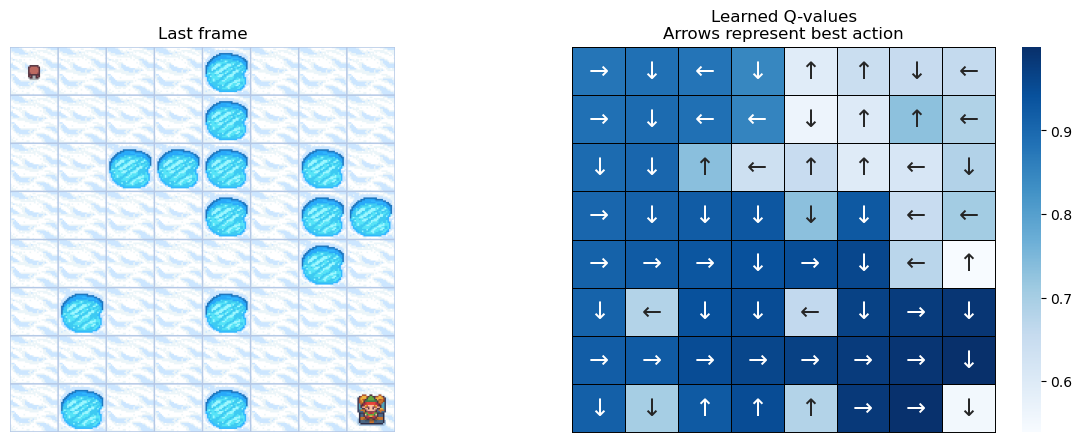

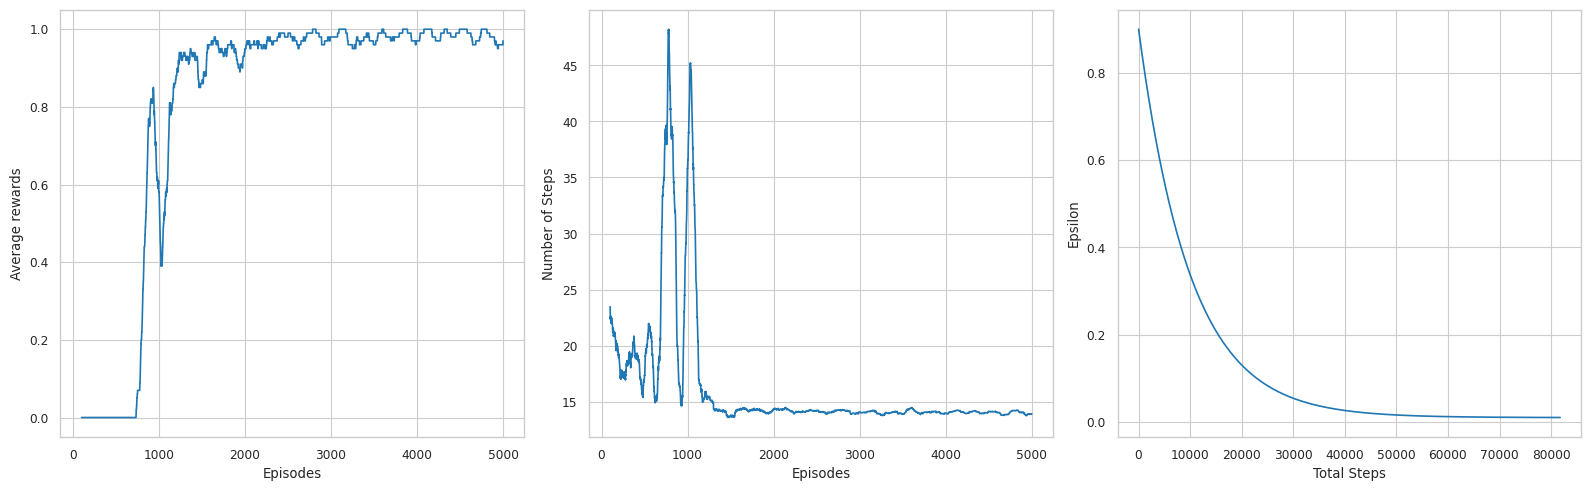

In [19]:
print(list(dql_agent.policy_net.parameters())[0].device)
dqn_induced_qtable = np.zeros((dql_agent.state_size, dql_agent.action_size))
states = F.one_hot(torch.arange(0, dql_agent.state_size), num_classes=dql_agent.state_size).float().to(dql_agent.device)
dql_agent.policy_net.eval()
with torch.no_grad():
    dqn_induced_qtable = dql_agent.policy_net(states).cpu().numpy()


num_params = sum(p.numel() for p in dql_agent.policy_net.parameters())
print("Total number of parameters in the DQN network:", num_params)
plot_q_values_map(dqn_induced_qtable, env, map_size)
plot_steps_rewards_epsilons(dql_plot_data, dql_epsilon_values)

Now, let’s see how well our Deep Q-Learning agent performs with the policy it has learned!

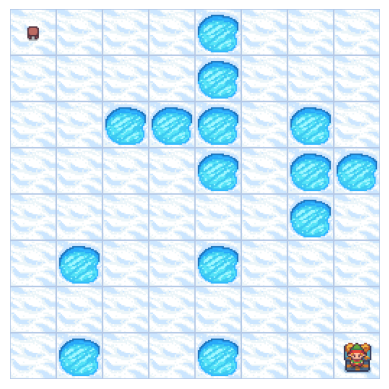

In [24]:
fig, ax = plt.subplots()

# Reset environment
state, info = env.reset()

# Teleport agent
env.unwrapped.s = 11
state = env.unwrapped.s   # update observation

done = False
while not done:
    # select an action (a) using the epsilon-greedy policy
    action = dql_agent.select_action(action_space=env.action_space, state=state)

    # Take the action (a) and observe the outcome state(s') and reward (r)
    new_state, reward, terminated, truncated, info = env.step(action)

    # code for rendering in notebook
    ax.clear(); ax.imshow(env.render()); ax.axis("off");
    display.display(fig); display.clear_output(wait=True);
    time.sleep(0.5)  

    # Our new state is state
    state = new_state

    # check if the episode is finished
    done = terminated or truncated

# Close the environment after all episodes are done
env.close()
plt.close()

While DQN is powerful, it also has important limitations:  

- **Action space:** Works only with *discrete* actions. Continuous actions require other methods (e.g., Policy Gradients, DDPG).  
- **Sample inefficiency:** Needs large amounts of data and replay memory to learn stable policies.  
- **Instability:** Training can still diverge without careful tuning of learning rate, exploration decay, and target network updates.  
- **Overestimation bias:** The max operator in the Bellman target can lead to over-optimistic Q-values.  

These challenges motivated improved algorithms such as **Double DQN**, **Dueling DQN**, and **Policy Gradient methods**.  